### Different python implementations of raster-space weighted voronoi

This is how we'd do (optionally, weighted) voronoi in numpy code. 

Can we turn this into gpu code using pycuda gpuarray?

Note that we're only using haversine (spherical) distance

In [1]:
import numpy as np

Set up test data

In [2]:
#oidUse
oidUse = np.array([3, 5, 6, 1, 2, 4, 7, 0])
#valUse
valUse = np.array([  68973.,  124745.,  160963.,  128893.,   54578.,  127628.,
         94394.,   53067.])
#latsUse
latsUse = np.array([-12.31252035, -15.71252035, -18.16252035, -18.91252035,
       -19.67085368, -21.44585368, -23.34585368, -25.16252035])
#lonsUse
lonsUse=np.array([ 49.28752035,  46.31252035,  49.37918701,  47.51252035,
        47.31252035,  47.06252035,  43.66252035,  46.07918701])
colLngs = np.arange(38,55,0.008333333333333)
rowLats = np.arange(-7,-31,-0.008333333333333)

Pre-calculate the radian conversions and the cosine of the latitudes

In [3]:
latRads = np.radians(rowLats)
lonRads = np.radians(colLngs)
cosLats = np.cos(latRads)

latsGrid = np.expand_dims(latRads,axis=1) #.repeat(axis=1, repeats=len(lonRads))
cosLatsGrid = np.expand_dims(cosLats,axis=1) #.repeat(axis=1, repeats=len(lonRads))
lonsGrid = np.expand_dims(lonRads,axis=0) #.repeat(axis=0, repeats=len(latRads))

latRadPoints = np.radians(latsUse)
lonRadPoints = np.radians(lonsUse)

## Numpy approach
vectorised function for calculating the spheroid distance between the whole grid space and a single point (adapted from https://stackoverflow.com/a/29546836)

In [4]:
def haversine_np(latGrid, cosLatGrid, lonGrid, latPoint, lonPoint):
    dLon = lonGrid - lonPoint
    dLat = latGrid - latPoint
    a = np.sin(dLat/2.0)**2 + cosLatGrid * np.cos(latPoint) * np.sin(dLon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6372.8 * c
    return km

In [22]:
import numexpr as ne
def haversine_cost_ne(latGrid, cosLatGrid, lonGrid, latPoint, lonPoint, costPoint):
    dLon = ne.evaluate("lonGrid - lonPoint")
    dLat = ne.evaluate("latGrid - latPoint")
    a = ne.evaluate("sin(dLat/2.0)**2 + cosLatGrid * cos(latPoint) * sin(dLon / 2.0)**2")
    cost = ne.evaluate("(2 * arcsin(sqrt(a)) * 6372.8) / costPoint")
    return cost

grids for output

In [29]:
assignmentsNP = np.empty(shape=(len(rowLats),len(colLngs)))
minScoresNP = np.empty(shape=(len(rowLats),len(colLngs)))
minScoresNP[:] = np.inf

In [28]:
%%timeit
for i in range(len(oidUse)):
    oid = oidUse[i]
    #dists = (np.sqrt((latsGrid-latsUse[i])**2 + (lonsGrid-lonsUse[i])**2)) / valUse[i]
    dists = haversine_np(latsGrid, cosLatsGrid, lonsGrid, latRadPoints[i], lonRadPoints[i]) / valUse[i]
    updateLocs = dists < minScoresNP
    assignmentsNP[updateLocs] = oid
    minScoresNP[updateLocs] = dists[updateLocs]
    

1 loop, best of 3: 1.8 s per loop


In [30]:
%%timeit
for i in range(len(oidUse)):
    oid = oidUse[i]
    #dists = (np.sqrt((latsGrid-latsUse[i])**2 + (lonsGrid-lonsUse[i])**2)) / valUse[i]
    costs = haversine_cost_ne(latsGrid, cosLatsGrid, lonsGrid, latRadPoints[i], lonRadPoints[i], valUse[i])
    updateLocs = dists < minScoresNP
    assignmentsNP[updateLocs] = oid
    minScoresNP[updateLocs] = dists[updateLocs]

1 loop, best of 3: 626 ms per loop


In [19]:
updateLocs.shape

(2881L, 2041L)

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

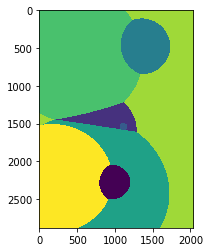

In [8]:
plt.imshow(assignmentsNP)

### Try for a CUDA version

First hack the path to get the cuda compiler working (horrible - this probably breaks other python compilations which rely on VC9.0)

In [11]:
import os
os.environ['PATH'] = 'C:\\OSGEO4~1\\apps\\Python27\\lib\\site-packages\\numpy\\core;C:\\OSGEO4~1\\apps\\Python27\\Scripts;C:\\Windows\\Microsoft.NET\\Framework64\\;C:\\Windows\\Microsoft.NET\\Framework64\\\\Microsoft .NET Framework 3.5 (Pre-Release Version);C:\\Windows\\Microsoft.NET\\Framework64\\v2.0.50727;C:\\Program Files\\Microsoft SDKs\\Windows\\v6.0A\\bin\\x64;C:\\Program Files\\Microsoft SDKs\\Windows\\v6.0A\\bin\\win64\\x64;C:\\Program Files\\Microsoft SDKs\\Windows\\v6.0A\\bin;C:\\Progra~2\\MICROS~3.0\\VC\\bin;C:\\OSGEO4~1\\bin;C:\\Windows\\system32;C:\\Windows;C:\\Windows\\WBem;C:\\Progra~1\\NVIDIA~2\\CUDA\\v8.0\\libnvvp;C:\\Progra~1\\NVIDIA~2\\CUDA\\v8.0\\bin;;C:\\OSGEO4~1\\apps\\msys\\bin;C:\\Program Files\\R\\R-3.4.1\\bin\\x64'

In [12]:
os.environ['PATH']

'C:\\OSGEO4~1\\apps\\Python27\\lib\\site-packages\\numpy\\core;C:\\OSGEO4~1\\apps\\Python27\\Scripts;C:\\Windows\\Microsoft.NET\\Framework64\\;C:\\Windows\\Microsoft.NET\\Framework64\\\\Microsoft .NET Framework 3.5 (Pre-Release Version);C:\\Windows\\Microsoft.NET\\Framework64\\v2.0.50727;C:\\Program Files\\Microsoft SDKs\\Windows\\v6.0A\\bin\\x64;C:\\Program Files\\Microsoft SDKs\\Windows\\v6.0A\\bin\\win64\\x64;C:\\Program Files\\Microsoft SDKs\\Windows\\v6.0A\\bin;C:\\Progra~2\\MICROS~3.0\\VC\\bin;C:\\OSGEO4~1\\bin;C:\\Windows\\system32;C:\\Windows;C:\\Windows\\WBem;C:\\Progra~1\\NVIDIA~2\\CUDA\\v8.0\\libnvvp;C:\\Progra~1\\NVIDIA~2\\CUDA\\v8.0\\bin;;C:\\OSGEO4~1\\apps\\msys\\bin;C:\\Program Files\\R\\R-3.4.1\\bin\\x64'

In [13]:
os.environ['CUDA_DEVICE']="1"

In [14]:
import pycuda.autoinit
import pycuda.gpuarray as gpuarray
from pycuda.elementwise import ElementwiseKernel
import pycuda.cumath

In [30]:
latsCuda = gpuarray.to_gpu(latsGrid)
lonsCuda = gpuarray.to_gpu(lonsGrid)
cosCuda = gpuarray.to_gpu(cosLatsGrid)

In [31]:
%timeit -n 100 (latsCuda*lonsCuda)

100 loops, best of 3: 19.4 ms per loop


In [32]:
%timeit(latsGrid*lonsGrid)


10 loops, best of 3: 21.9 ms per loop


Now the main distance implementation. Props to http://www.vallis.org/salon/summary-10.html

In [33]:
def haversine_cuda(gpuLatGrid, gpuCosLatGrid, gpuLonGrid, pointLat, pointLon):
    
    #subtr = ElementwiseKernel("float *arr, float x, float *z", "z[i] = *arr[i] - x", "subtract")
    #dLon = gpuarray.empty_like(gpuLonGrid)
    #dLat = gpuarray.empty_like(gpuLatGrid)
    #subtr(gpuLonGrid, pointLon, dLon)
    #subtr(gpuLatGrid, pointLat, dLat)
    dLon = gpuLonGrid - np.float32(pointLon)
    dLat = gpuLatGrid - np.float32(pointLat)
    npTwo = np.float32(2)
    a = pycuda.cumath.sin(dLat/npTwo)**npTwo + gpuCosLatGrid * np.cos(pointLat) * pycuda.cumath.sin(dLon / npTwo)**npTwo
    c = 2 * pycuda.cumath.asin(pycuda.cumath.sqrt(a))
    km = np.float32(6372.8) * c
    return km

In [17]:
%timeit haversine_cuda(latsCuda, cosCuda, lonsCuda, latRadPoints[1], lonRadPoints[1])

10 loops, best of 3: 137 ms per loop


In [19]:
%timeit haversine_np(latsGrid, cosLatsGrid, lonsGrid, latRadPoints[1], lonRadPoints[1])

10 loops, best of 3: 106 ms per loop


In [34]:
assignmentsCuda = np.empty(shape=(len(rowLats),len(colLngs)))
minScoresCuda = np.empty(shape=(len(rowLats),len(colLngs)))
minScoresCuda[:] = np.inf

In [38]:
%%timeit
for i in range(len(oidUse)):
    oid = oidUse[i]
    #dists = (np.sqrt((latsGrid-latsUse[i])**2 + (lonsGrid-lonsUse[i])**2)) / valUse[i]
    dists = (haversine_cuda(latsCuda, cosCuda, lonsCuda, latRadPoints[i], lonRadPoints[i]) / valUse[i]).get()
    updateLocs = dists < minScoresCuda
    assignmentsCuda[updateLocs] = oid
    minScoresCuda[updateLocs] = dists[updateLocs]

1 loop, best of 3: 4.6 s per loop


In [36]:
assignmentsCuda

array([[ 5.,  5.,  5., ...,  6.,  6.,  6.],
       [ 5.,  5.,  5., ...,  6.,  6.,  6.],
       [ 5.,  5.,  5., ...,  6.,  6.,  6.],
       ..., 
       [ 7.,  7.,  7., ...,  6.,  6.,  6.],
       [ 7.,  7.,  7., ...,  6.,  6.,  6.],
       [ 7.,  7.,  7., ...,  6.,  6.,  6.]])

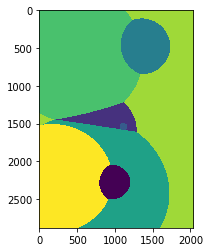

In [37]:
plt.imshow(assignmentsCuda)

Soooo.... it works but is loads slower than CPU at least with the crappy GPU i've got here